In [ ]:
import pickle
import re

import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from itertools import chain, groupby

import pycrfsuite
import numpy as np
import pandas as pd
import random
import math
#import itertools
from collections import Counter, OrderedDict
from os.path import exists as file_exists

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from PIL import Image



2022-04-19 01:27:43 INFO: Downloading default packages for language: en (English)...


2022-04-19 01:27:55 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-04-19 01:27:55 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-04-19 01:27:55 INFO: Use device: cpu
2022-04-19 01:27:55 INFO: Loading: tokenize
2022-04-19 01:27:55 INFO: Loading: pos
2022-04-19 01:27:56 INFO: Done loading processors!


# Tag goes here

In [ ]:
def remove_spaces_from_term(term_with_spaces):
    return term_with_spaces.replace(' ', '')

def swap_spaces_for_underscore(term_with_spaces):
    return term_with_spaces.replace(' ', '_')

In [ ]:
# term_content = dict(itertools.islice(term_content.items(), 2))
# temp_dict = dict()
# for k, v in term_content.items():
#     temp_dict[k] = dict(itertools.islice(v.items(), 100))

# term_content = temp_dict
# term_content

In [ ]:
# key = "MicroMacro: Crime City" #'The Castles of Burgundy'

# key_nothing_in_parens = re.sub(r'\([^)]*\)', '', key).strip()
# key_nothing_in_parens = re.sub(r'[^\w\s]', '', key_nothing_in_parens).split()

# key_nothing_in_parens

In [ ]:
def get_clean_parsed_key_from_parsed_sentence(nlp_sent):
    
    parens_idx = -4        
    # for word in nlp_sent.tokens:
    #     if word.text == '(': # remove explanatory text in parens after wiki_key
    #         parens_idx = word.id[0] - 1
    #         break    

    #print('parens:', parens_idx)
    parsed_key = [term.text for term in nlp_sent.tokens[:parens_idx]] # length of seperator above
    parsed_key = parsed_key[1:-1] # length of seperator above
    #print("new:", parsed_key)

    return parsed_key   

# test_key = nlp('"Puerto Rico" in a thing.').sentences[0]
# test_key.tokens
# get_clean_parsed_key_from_parsed_sentence(test_key)

# Tag 2

In [ ]:
def get_idxs_of_sublist_matches(big_list, substring_to_find):
    indexes = []

    # https://stackoverflow.com/questions/10459493/find-indexes-of-sequence-in-list-in-python
    for i in range(len(big_list)):
        if big_list[i:i+len(substring_to_find)] == substring_to_find:
            indexes.append((i, i+len(substring_to_find)))

    return indexes

In [ ]:
#get_idxs_of_substring_matches(term_content[test_key], test_key)

In [ ]:
def expand_all_tups_to_list(tup_list):
    
    exp_list = []
    for tup in tup_list:
        exp_list.extend(list(range(tup[0], tup[1])))
    return exp_list

In [ ]:
def clean_text_for_crf_parsing(text):
    text = text.replace('\n', '')
    text = text.replace('+/u/sodogetip', '')
    sent_remove_between_equals = re.sub(r'==[^=]*==', '', text).strip() 

    return sent_remove_between_equals


In [ ]:
def return_parsed_words_and_pos_tuples(stanza_nlp_doc, first_is_key=False):
    
    all_sents = []
    parsed_key = ''
    for idx, sent in enumerate(stanza_nlp_doc.sentences):
        if (first_is_key & (idx == 0)): # first sentence("xxx" is a thing.), because we concatenated the 'key' to the text

            #print('first sent:', [term.text for term in sent.tokens])

            # parens_idx = -4        
            # for word in sent.tokens:
            #     if word.text == '(': # remove explanatory text in parens after wiki_key
            #         parens_idx = word.id[0] - 1
            #         break    

            # #print('parens:', parens_idx)
            # parsed_key = [term.text for term in sent.tokens[:parens_idx]] # length of seperator above
            # parsed_key = parsed_key[1:-1] # length of seperator above
            # print("new:", parsed_key)
            parsed_key = get_clean_parsed_key_from_parsed_sentence(sent)
        else:            
            # real wiki text starts now
            nlp_parsed_sent = [(word.text, word.upos) for token in sent.tokens for word in token.words]
            # all_sents is a list of tuples, (the_word, part_of_speech) for each word in a sentence
            all_sents.append(nlp_parsed_sent)

            # if (idx == 1):
            #     print('nlp_parsed:', nlp_parsed_sent)
        # add 'word.xpos,' later

    #key_words = [ss.upper() for ss in parsed_key]

    return parsed_key, all_sents 

In [ ]:
def label_traing_data_for_crf(key_words, stanza_word_pos_tuples):
    
    list_of_labeled_sentences_in_cat = []
    
    for idx_all, sent in enumerate(stanza_word_pos_tuples):
        #print(sent) 
        list_of_single_sentence = []   
        list_of_only_words_from_parsed_tuple = [st[0].upper() for st in sent]

        key_words = [kw.upper() for kw in key_words]    

        indexes = get_idxs_of_sublist_matches(list_of_only_words_from_parsed_tuple, key_words)

        # # https://stackoverflow.com/questions/10459493/find-indexes-of-sequence-in-list-in-python
        # for i in range(len(list_of_only_words_from_parsed_tuple)):
                        
        #     if list_of_only_words_from_parsed_tuple[i:i+len(key_words)] == key_words:
        #         indexes.append((i, i+len(key_words)))

        # #all_sents[0], indexes

        # This is to expand the indexes tuple above (3,6), into a list [3,4,5,6]
        # to know all the indexes in which to put 'Y's, the rest being 'N's
        for idx, tup in enumerate(sent):
            if idx in expand_all_tups_to_list(indexes):
                tup = tup+('Y',)
            else:
                tup = tup+('N',)

            # (',', 'PUNCT', 'N'),
            if (tup[0] == ',') & (tup[1] == 'PUNCT') & (tup[2] == 'Y'):
                tup = (',', 'PUNCT', 'N')
            list_of_single_sentence.append(tup)

        list_of_labeled_sentences_in_cat.append(list_of_single_sentence)

        # if idx_all == 0:
        #     print('labeled:', list_of_single_sentence)

    return list_of_labeled_sentences_in_cat

In [ ]:
%%time
# New version with single call to stanza nlp library per term

def get_parsed_labeled_sentences_from_cat_dict(term_content, mvp_flag, wiki_term):
    labeled_sentences_per_cat = dict()
    pkl_file_name = './output_step5/dict200_labeled_cat_sentences_' + swap_spaces_for_underscore(wiki_term) + '.pickle'

    if mvp_flag and file_exists(pkl_file_name):
        print('mvp! wikipedia article already parsed and labeled.')
        with open(pkl_file_name, 'rb') as handle:
            labeled_sentences_per_cat = pickle.load(handle)
    else:


        for k_cat,v_cat_dicts in term_content.items():
            list_of_labeled_sentences_in_cat = []
            for wiki_key,v_wiki_text in v_cat_dicts.items():
                
                clean_key = re.sub(r'\([^)]*\)', '', wiki_key).strip()
                #parsed_key = get_clean_parsed_key(wiki_key)

                clean_text_to_parse = clean_text_for_crf_parsing(v_wiki_text)
                seperator = '" is a thing. ' # 4 items parsed from here: 3 words and period

                #print('seperator:', seperator)
                # added double-ticks into here , to seperate out the 'key' for stanza
                doc = nlp('"' + clean_key + seperator + clean_text_to_parse)

                
                key_words, parsed_word_pos_sentences = return_parsed_words_and_pos_tuples(doc, True)
                #print(key_words)
                
                list_of_labeled_sentences_in_cat.append(label_traing_data_for_crf(key_words, parsed_word_pos_sentences))


            # result is a dictionary, with wiki categories as keys, and values being a list of lists of sentences
            # 'Category:Territorial acquisition and development games': 
            #    [[('Space', 'PROPN', 'Y'),
            #    ('Empires', 'PROPN', 'Y'),
            #    ('4X', 'PROPN', 'Y'),
            #    ('is', 'AUX', 'N'),
            #    ('a', 'DET', 'N'),
            #    ('4X', 'ADJ', 'N'),.......

            labeled_sentences_per_cat[k_cat] = list_of_labeled_sentences_in_cat

        print('Dumping:', pkl_file_name)
        with open(pkl_file_name, 'wb') as handle:
            pickle.dump(labeled_sentences_per_cat, handle, protocol=pickle.HIGHEST_PROTOCOL)

        # This is Conditional Random Field training data for each category
    return labeled_sentences_per_cat

# dict_labeled_cat_sentences = get_parsed_labeled_sentences_from_cat_dict(term_content, mvp_flag, wiki_term)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [ ]:
# https://notebook.community/thammegowda/notes/nlproc/hw3/notes/pycrf_tutorial


In [ ]:
#list_combined_cats_labeled_sentences[0]

In [ ]:
def create_labeled_training_data_from_wikipedia(wiki_term, mvp_flag):
    print("Wikipedia term:", wiki_term)
    
    # Load Wikipedia articles created in Step 1
    with open('./output_step1/wiki_200_cat_content_' + swap_spaces_for_underscore(wiki_term) + '.pickle', 'rb') as handle:
        term_content = pickle.load(handle)

    # See how many wikipedia article we're workign with
    print("See wikipedia categories and number of article saved as training data to be labeled.")
    cume_number_of_items = 0
    for k,v in term_content.items():
        cume_number_of_items = cume_number_of_items + len(v)
        print(k, cume_number_of_items, len(v))

    dict_labeled_cat_sentences = get_parsed_labeled_sentences_from_cat_dict(term_content, mvp_flag, wiki_term)

    list_combined_cats_labeled_sentences = []

    for k_category,v_cat_items in dict_labeled_cat_sentences.items():
        for sent in v_cat_items:
            list_combined_cats_labeled_sentences.extend(sent)
        
    print(len(list_combined_cats_labeled_sentences), 'sentences from wikipedia available to train on')

    labels = Counter()
    for sentence in list_combined_cats_labeled_sentences:
        for word_pos_tup in sentence:
            labels.update(word_pos_tup[2])
    print(labels, 'numbers of each label from wikipedia')

    return list_combined_cats_labeled_sentences



In [ ]:
def train_test_split_labeled_sentences(docs):
    random.seed(42)
    random.shuffle(docs)

    tot_sentences = len(docs)


    len_train_sents = math.floor((tot_sentences * .8))
    len_test_sents = tot_sentences - len_train_sents
    assert len_train_sents + len_test_sents == tot_sentences, "boo"

    train_sents = docs[:len_train_sents]
    test_sents = docs[len_train_sents:]

    return train_sents, test_sents

In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag[:2]=' + postag[:2],
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1,
            '-1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:postag=' + postag1,
            '+1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('EOS')
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [ ]:
def get_x_y_features_labels(train_sents, test_sents):
    X_train = [sent2features(s) for s in train_sents]
    y_train = [sent2labels(s) for s in train_sents]

    X_test = [sent2features(s) for s in test_sents]
    y_test = [sent2labels(s) for s in test_sents]

    return X_train, y_train, X_test, y_test

In [ ]:
def return_trained_tagger(X_train, y_train, wiki_term, mvp_flag):
    
    crf_model_file_name = './output_step5/tagger_200_' + swap_spaces_for_underscore(wiki_term) + '.crfsuite'

    tagger = pycrfsuite.Tagger()

    if not (mvp_flag and file_exists(crf_model_file_name)):
        trainer = pycrfsuite.Trainer(verbose=False)
        max_sentences = 10000
        print('Trainer created, will use max of', max_sentences, 'of', len(X_train), 'items')
        for xseq, yseq in zip(X_train[:max_sentences], y_train[:max_sentences]):
            trainer.append(xseq, yseq)
        print('Training data joined')
        trainer.set_params({
        'c1': 1.0,   # coefficient for L1 penalty
        'c2': 1e-3,  # coefficient for L2 penalty
        'max_iterations': 200,  # stop earlier

        # include transitions that are possible, but not observed
        'feature.possible_transitions': True
        })

        print('training with params:', trainer.params())

        # Train model
        trainer.train(crf_model_file_name) # 50- 10secs, 200-38secs

        print('trainer_features:', trainer.logparser.last_iteration)
    else:
        print('mvp! using existing tagger file')
    
    tagger.open(crf_model_file_name)

    return tagger


In [ ]:


def print_example_sentence(test_sents, tagger):
    print("Sample test sentence and predicted/actual tags")
    example_sent = test_sents[0]
    print(' '.join(sent2tokens(example_sent)), end='\n\n')

    print("Predicted:", ' '.join(tagger.tag(sent2features(example_sent))))
    print("Actual:  ", ' '.join(sent2labels(example_sent)))


In [ ]:
def bio_classification_report(y_true, y_pred):
    """
    Classification report for a list of BIO-encoded sequences.
    It computes token-level metrics and discards "O" labels.
    
    Note that it requires scikit-learn 0.15+ (or a version from github master)
    to calculate averages properly!
    """
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    )

In [ ]:
def classification_report_df(report):
    report_data = []
    lines = report.split('\n')
    del lines[-5]
    del lines[-1]
    del lines[1]
    for line in lines[1:3]:
        row = OrderedDict()
        row_data = line.split()
        #print(row_data)
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = int(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    return df

def get_model_accuracy_df(tagger, X_test, y_test):
    y_pred = [tagger.tag(xseq) for xseq in X_test]

    report = bio_classification_report(y_test, y_pred)
    return classification_report_df(report).reset_index()



In [ ]:

def get_clean_unseen_text_to_predict(wiki_term):

    pkl_file_name = './output_step4/posts_' + swap_spaces_for_underscore(wiki_term) + '.pickle'
    with open(pkl_file_name, 'rb') as handle:
        related_posts = pickle.load(handle)

    unseen_text = [clean_text_for_crf_parsing(i) for i in related_posts[:]]

    print("Number of Sentences in Reddit text:", len(unseen_text))
    print("Some example sentences:")
    for i in unseen_text[:10]:
        print(i) 

    return unseen_text



In [ ]:
# related_posts = ['Good shonen anime similar to Demon Slayer or Hunter X Hunter?',
#  'Looking for shows like Ratched, Undercover, Collateral, Brand New Cherry Flavor, Zero Zero Zero, Mr. Robot, The Haunting Of The Hill House, Bordertown, Better Call Saul, or Bob?',
#  'Korean wave be like :. well the drama is fun but its nowhere near to best writing. Seem like you are just new with kdramas. Because best writing being associated more with kdramas like signal, kingdom, mr sunshine, misaeng,etc.',
#  "[REQUEST] tv shows similar to Mcmafia. I watched it recently on AMC+.  Avoided it for so long because of the name, surprisingly ended up really enjoying it.  I loved the international feeling of it.  Can't wait for season 2.",
#  'Korean wave be like :. Wc👌',
#  'Korean wave be like :. Even squid game is much better drama than CLOY. I watched both dramas. Both are fun of course. Personally, i found squid game much better drama than CLOY too. I am pretty sure you not yet to watch dramas that i suggested.',
#  "My flat mate has taken the security of the milk in next level. He cut one milk bottle into half and put on top of the new one and lock it so nobody can try to steal milk from him.. That's nothing a little steak knife can't fix."] + \
#  related_posts


In [ ]:


def get_new_crf_phrases_counts_from_clean_unseen_posts(unseen_text, tagger, mvp_flag, wiki_term):
    
    crf_tagged_pkl_file = './output_step5/counter_crf_tagged_phrases_' + swap_spaces_for_underscore(wiki_term) + '.pickle'
    crf_exact_pkl_file = './output_step5/counter_crf_exact_phrases_' + swap_spaces_for_underscore(wiki_term) + '.pickle'
    crf_tagged_phrases_in_text = Counter()
    crf_exact_phrases_in_text = Counter()

    if mvp_flag and file_exists(crf_tagged_pkl_file) and file_exists(crf_exact_pkl_file):
        print('mvp!')
        with open(crf_tagged_pkl_file, 'rb') as handle:
            crf_tagged_phrases_in_text = pickle.load(handle)
        with open(crf_exact_pkl_file, 'rb') as handle:
            crf_exact_phrases_in_text = pickle.load(handle)
    else:            

        for sentence in unseen_text[:]:
            doc = nlp(sentence)
            _, unseen_parsed_word_pos_sentences = return_parsed_words_and_pos_tuples(doc, False)
            #print('uns:', unseen_parsed_word_pos_sentences)
            X_unseen = [sent2features(s) for s in unseen_parsed_word_pos_sentences]
            y_unseen_pred = [tagger.tag(xseq) for xseq in X_unseen]

            #print('yun:', y_unseen_pred)

            #new_big_list_sentences = []
            for idx_big, parsed_sent in enumerate(unseen_parsed_word_pos_sentences):
                new_small_sentence = []
                
                # new_phrases_found = []
                # idx_seen = []
                #'n,n,Y,Y,n,n,n,n,Y,Y,Y,n,n'
                for idx_small, tup in enumerate(parsed_sent[:]):
                    #unseen_pred = y_unseen_pred[idx_big][idx_small]
                    
                    new_small_sentence.append((tup[0], y_unseen_pred[idx_big][idx_small] ))

                    # https://stackoverflow.com/questions/71746563/finding-consecutive-groupings-of-items-in-list-of-lists-in-python
                found_phrases_in_sent = [ ' '.join(i[0] for i in b)for a, b in groupby(new_small_sentence, key=lambda x:x[1]) if a=='Y']
                
                if len(found_phrases_in_sent)> 0:
                    #print('Found:', found_phrases_in_sent)

                    for found_phrase in found_phrases_in_sent:

                        # for each item in found_phrases_in_sent, only once
                        # if it's in the counter, we've seen it
                        # for each found entity, we're going to spin through all the posts
                        # and look for exact matches
                        if found_phrase.upper() not in crf_tagged_phrases_in_text:
                            for post in unseen_text: # checking for exact matches of CRF terms in posts
                                
                                remove_spaces = [' .', ' ?', ' !', ' :', " N'T", ' -', '- ', " 'S", " 'D", " 'VE", " 'RE", " 'M", " 'LL"]
                                found_phrase_no_spaces = str(found_phrase)
                                for rem_sp in remove_spaces:
                                    found_phrase_no_spaces = found_phrase_no_spaces.replace(rem_sp, rem_sp.replace(' ', ''))
                                                                
                                crf_exact_phrases_in_text.update({found_phrase.upper(): post.upper().count(found_phrase_no_spaces.upper()) })


                    crf_tagged_phrases_in_text.update([i.upper() for i in found_phrases_in_sent])

                    #new_big_list_sentences.append(new_small_sentence)
                    #print('prs:', parsed_sent)

            #print([tup for sent in new_big_list_sentences for tup in sent])
            #print(new_big_list_sentences)

        print('Dumping:', crf_tagged_pkl_file, crf_exact_pkl_file)
        with open(crf_tagged_pkl_file, 'wb') as handle:
            pickle.dump(crf_tagged_phrases_in_text, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(crf_exact_pkl_file, 'wb') as handle:
            pickle.dump(crf_exact_phrases_in_text, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return crf_tagged_phrases_in_text, crf_exact_phrases_in_text



In [ ]:
#new_phrases_found_from_crf.most_common()

In [ ]:
# try to evaluate true counts from unseen data, based on exact match
# should have identical keys as above
#exact_crf_phrase_in_text.most_common()

In [ ]:

def check_unseen_against_wiki_whitelist(wiki_term, unseen_text):

    pkl_file_name = './output_step1/white_list_200_' + swap_spaces_for_underscore(wiki_term) + '.pickle'
    with open(pkl_file_name, 'rb') as handle:
        wiki_white_list = pickle.load(handle)

    exact_wiki_phrase_in_text = Counter()
    all_wiki_articles = set()

    for key_cat, val_list_articles in wiki_white_list.items():
            all_wiki_articles.update(val_list_articles)

    for sentence in unseen_text:
        sentence = sentence.upper()  

        for article in all_wiki_articles:
            if article.upper() in sentence:
                exact_wiki_phrase_in_text.update([article.upper()])
    
    return exact_wiki_phrase_in_text
    
def return_final_df(wiki_term, exact_wiki_phrase_in_text, new_phrases_found_from_crf, exact_crf_phrase_in_text):    
    df_wiki_white = pd.DataFrame.from_dict(exact_wiki_phrase_in_text.most_common())
    df_wiki_white.columns = ['Word', 'Exact_Whitelist']
    df_wiki_white = df_wiki_white.set_index('Word')

    df_crf_results = pd.DataFrame({'CRF_Model_Found': new_phrases_found_from_crf, 'Exact_CRF': exact_crf_phrase_in_text})
    df_crf_results = df_crf_results.join(df_wiki_white , how='outer')

    df_crf_results['CRF_Recall'] = df_crf_results['CRF_Model_Found']/df_crf_results['Exact_CRF']

    df_crf_results = df_crf_results.reset_index()
    df_crf_results = df_crf_results.rename(columns={'index': 'Entity'})

    df_crf_results = df_crf_results.sort_values(by=['CRF_Model_Found', 'Exact_CRF', 'CRF_Recall', 'Entity'], ascending=[False, False, False, True], na_position='last')
    df_crf_results.to_csv('./output_step5/crf_results_' + swap_spaces_for_underscore(wiki_term) + '.csv', encoding='utf-8', index=False)
    df_crf_results.to_csv('./streamlit/example_output/crf_results_' + swap_spaces_for_underscore(wiki_term) + '.csv', encoding='utf-8', index=False)

    return df_crf_results




In [ ]:
#wiki_white_list

In [ ]:
# see if any are not in white list
# check for upper and letter upper/lower case
# eval accuracy at each step
# github readme
# Context of wikipedia is different from reddit for CRF model
# try getting rid of commas and 'Y'
# try exact match against whitelist
# try Spacy near

In [ ]:
#intro and motivation, novel item, from scikit

In [ ]:
%%time


def calculate_final_results_for_wiki_term(wiki_term, mvp_flag):
    docs = create_labeled_training_data_from_wikipedia(wiki_term, mvp_flag)

    train_sents, test_sents = train_test_split_labeled_sentences(docs)
    X_train, y_train, X_test, y_test = get_x_y_features_labels(train_sents, test_sents)
    print('Ready to train.')
    tagger = return_trained_tagger(X_train, y_train, wiki_term, mvp_flag)

    print_example_sentence(test_sents, tagger)

    print(swap_spaces_for_underscore(wiki_term))
    print(get_model_accuracy_df(tagger, X_test, y_test ))

    unseen_text = get_clean_unseen_text_to_predict(wiki_term)

    new_phrases_found_from_crf, exact_crf_phrase_in_text = get_new_crf_phrases_counts_from_clean_unseen_posts(unseen_text, tagger, mvp_flag, wiki_term)

    exact_wiki_phrase_in_text = check_unseen_against_wiki_whitelist(wiki_term, unseen_text)
    df_final = return_final_df(wiki_term, exact_wiki_phrase_in_text, new_phrases_found_from_crf, exact_crf_phrase_in_text)
    print(wiki_term, 'finished')
    return df_final

#calculate_final_results_for_wiki_term('Beastie Boys', True)


Wikipedia term: Catan
See wikipedia categories and number of article saved as training data to be labeled.
Category:Board games introduced in 2018 6 6
Category:Embracer Group franchises 89 83
Category:Board games introduced in 2020 94 5
Category:Territorial acquisition and development games 95 1
Category:Multiplayer games 157 62
Category:Board games with a modular board 200 43
Category:Board games introduced in 2019 208 8
Category:Board games introduced in 1995 222 14
mvp! wikipedia article already parsed and labeled.
13999 sentences from wikipedia available to train on
Counter({'N': 322591, 'Y': 5738}) numbers of each label from wikipedia
Ready to train.
mvp! using existing tagger file
Sample test sentence and predicted/actual tags
The player with the most victory points at the end of the game is the winner .

Predicted: N N N N N N N N N N N N N N N N N
Actual:   N N N N N N N N N N N N N N N N N
Catan
  class  precision  recall  f1_score  support
0     N        1.0    1.00      1.00

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
def make_wordcloud(df, title = 'Top CRF Results'):  

    res = dict(zip(df['Entity'].dropna(), df['CRF_Model_Found'].dropna().astype('int32')))

    def custom_color_func(word, font_size, position, orientation, random_state=None,
                        **kwargs):
        return "hsl(0, 100%%, %d%%)" % random.randint(30, 70)

    reddit_mask = np.array(Image.open("./streamlit/images/reddit-logo5-2.jpg"))

    wordcloud = WordCloud(width=800,
                    height=800,
                    background_color="white", 
                        mask=reddit_mask,
                        contour_width=0, 
                        repeat=True,
                        min_font_size=3,
                        contour_color='red')

    # Generate a wordcloud
    wordcloud.generate_from_frequencies(res)

    # store to file
    #wordcloud.to_file("img_dir/dove_wordcloud.png")

    # show
    plt.figure( figsize=(10,10) )
    #plt.imshow(wordcloud)

    plt.annotate(title, xy =(200, 200),
                xytext =(20, 20),
                fontsize=20
                )

    plt.imshow(wordcloud.recolor(color_func=custom_color_func, random_state=3),
            interpolation="bilinear")

    plt.axis("off")
    plt.show()

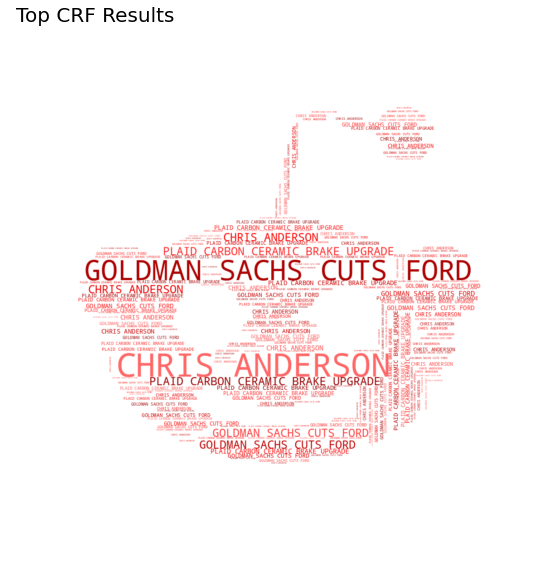

In [ ]:

# df = pd.read_csv('/work/MADS_698_Capstone/output_step5/crf_results_Elon_Musk.csv')
# make_wordcloud(df)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90b052a7-f47d-474e-888f-9345355cfd9a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>